In [1]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pyeit.mesh as mesh
import tensorflow as tf
from PIL import Image
from pyeit.mesh.shape import thorax
from sciopy import norm_data, plot_mesh
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from support import GREIT_sample, show_mesh
from tensorflow import GradientTape, keras, shape
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tqdm import tqdm

2023-11-02 09:48:16.257040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Predict Breathing

- Optimize the current reconstruction using some past information and shared wheights.

![SegmentLocal](breathing.gif "segment")

In [2]:
load_mesh_raw = False
tmp = np.load(
    "../data_thorax/h0=0.025_n_el=16_r_min=0.1_r_max=0.4_dist_exc=8_step_meas=4noise=True/sample_000000.npz",
    allow_pickle=True,
)
tmp.files

if load_mesh_raw:
    # create empty mesh:
    mesh_obj = mesh.create(tmp["n_el"], h0=tmp["h0"], fd=thorax)
    
    mesh_obj.perm = tmp["perm_array"]
    plot_mesh(mesh_obj)

In [29]:
l_path = "../data_thorax/h0=0.025_n_el=16_r_min=0.1_r_max=0.4_dist_exc=8_step_meas=4noise=True/"
V = list()
radii = list()

for ele in tqdm(np.sort(os.listdir(l_path))):
    tmp_l = np.load(l_path + ele, allow_pickle=True)
    V.append(tmp_l["v_obj"])
    radii.append(tmp_l["anomaly"][0].r)

V = np.array(V)
radii = np.array(radii)

100%|██████████| 10000/10000 [00:23<00:00, 418.14it/s]


<StemContainer object of 3 artists>

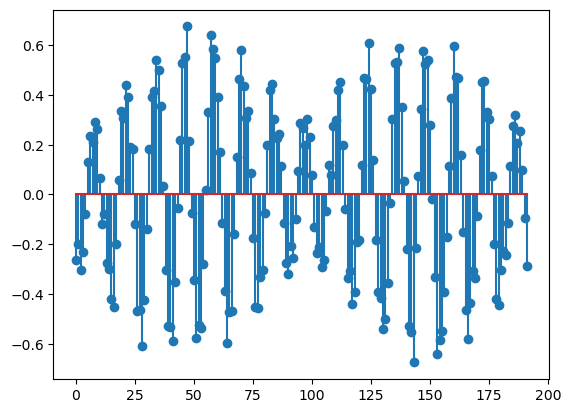

In [30]:
plt.stem(V[0,:])

### Model

In [43]:
latent_dim = 4
nseg = 6

kernel_size = 4


def encoder_model(latent_dim=latent_dim, nseg=nseg, kernel_size=4):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.backend.random_normal(
            shape=(keras.backend.shape(z_mean)[0], latent_dim)
        )
        return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

    def slice_enconder(s):
        def func(x):
            return x[:, s, :, :]

        return func

    def slice_lstm(s):
        def func(x):
            return x[:, s, :]

        return func

    # start encoder model
    encoder_inputs = keras.Input(shape=(nseg, 192, 1))
    # inputs = tf.keras.layers.ZeroPadding2D(padding=((0, 4)))(encoder_inputs)
    inputs = encoder_inputs

    # Build conv layers for wheight sharing
    conv1d_l1 = layers.Conv1D(
        64, activation="relu", kernel_size=3, strides=2, padding="same"
    )
    conv1d_l2 = layers.Conv1D(
        32, activation="relu", kernel_size=3, strides=2, padding="same"
    )
    conv1d_l3 = layers.Conv1D(
        16, activation="relu", kernel_size=3, strides=2, padding="same"
    )
    conv1d_l4 = layers.Conv1D(
        8, activation="relu", kernel_size=3, strides=2, padding="same"
    )
    flatten_1 = layers.Flatten()
    dense_1 = layers.Dense(16, activation="relu")

    z_mean_list = list()
    z_var_list = list()

    for s in range(nseg):
        x = layers.Lambda(slice_enconder(s))(inputs)
        x = conv1d_l1(x)
        x = conv1d_l2(x)
        x = conv1d_l3(x)
        x = conv1d_l4(x)
        x = flatten_1(x)
        x = dense_1(x)
        
        z_mean = layers.Dense(latent_dim, name=f"z_mean_{s}")(x)
        z_log_var = layers.Dense(latent_dim, name=f"z_log_var_{s}")(x)

        z_mean_list.append(z_mean)
        z_var_list.append(z_log_var)

    z_mean = layers.Concatenate(axis=1)(z_mean_list)
    z_mean = layers.Reshape((nseg, int(z_mean.shape[1] / nseg)))(z_mean)

    z_var = layers.Concatenate(axis=1)(z_var_list)
    z_var = layers.Reshape((nseg, int(z_var.shape[1] / nseg)))(z_var)

    # hier LSTMs
    ### mean block
    lstm_list_mean = list()
    for s in range(nseg):
        lstm_mean = layers.Lambda(slice_lstm(s))(z_mean)
        lstm_mean = layers.Dense(latent_dim, activation="relu")(lstm_mean)
        lstm_list_mean.append(lstm_mean)
    # concat and reshape for LSTM
    lstm_mean = layers.Concatenate(axis=1)(lstm_list_mean)
    lstm_mean = layers.Reshape((nseg, int(lstm_mean.shape[1] / nseg)))(lstm_mean)
    lstm_mean = layers.LSTM(latent_dim)(lstm_mean)
    lstm_mean = layers.Activation("softmax")(lstm_mean)
    ### mean block

    ### var block
    lstm_list_var = list()
    for s in range(nseg):
        lstm_var = layers.Lambda(slice_lstm(s))(z_var)
        lstm_var = layers.Dense(latent_dim, activation="relu")(lstm_var)
        lstm_list_var.append(lstm_var)
    # concat and reshape for LSTM
    lstm_var = layers.Concatenate(axis=1)(lstm_list_var)
    lstm_var = layers.Reshape((nseg, int(lstm_var.shape[1] / nseg)))(lstm_var)
    lstm_var = layers.LSTM(latent_dim)(lstm_var)
    lstm_var = layers.Activation("softmax")(lstm_var)
    ### var block
    # end LSTM

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")(
        [lstm_mean, lstm_var]
    )

    return encoder_inputs, lstm_mean, lstm_var, z


# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

In [44]:
def decoder_model(latent_dim=latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(16, activation="relu")(latent_inputs)
    x = layers.Dense(96, activation="relu")(x)
    x = layers.Reshape((12, 8))(x)
    x = layers.Conv1DTranspose(
        16, activation="relu", kernel_size=3, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        32, activation="relu", kernel_size=3, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        64, activation="relu", kernel_size=3, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        128, activation="relu", kernel_size=3, strides=2, padding="same"
    )(x)
    x = layers.Conv1DTranspose(
        1, activation="relu", kernel_size=1, strides=1, padding="same"
    )(x)

    decoder_outputs = layers.Flatten()(x)
    return latent_inputs, decoder_outputs

In [45]:
def vae_model():
    encoder_inputs, z_mean, z_log_var, z = encoder_model()
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")
    encoder.summary()

    decoder_inputs, decoder_outputs = decoder_model()
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")
    decoder.summary()

    return VAE(encoder, decoder)

In [46]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)[0]
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.losses.mean_squared_error(data[0, 0, :], reconstruction))#, axis=1
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [47]:
vae = vae_model()

2023-11-02 09:57:57.548513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-02 09:57:57.549674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-02 09:57:57.550482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 6, 192, 1)]  0           []                               
                                                                                                  
 lambda_36 (Lambda)             (None, 192, 1)       0           ['input_4[0][0]']                
                                                                                                  
 lambda_37 (Lambda)             (None, 192, 1)       0           ['input_4[0][0]']                
                                                                                                  
 lambda_38 (Lambda)             (None, 192, 1)       0           ['input_4[0][0]']                
                                                                                        

In [48]:
vae.compile(optimizer="adam")

In [49]:
X = [V[n : n + nseg, :] for n in range(V.shape[0] - nseg + 1)]
X = np.expand_dims(X,3)

Y = np.array(V[nseg - 1 :])

# X = | t0 | t1 | t2 | t3  
# Y = | __ | __ | __ | t3  

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.1, shuffle=False, random_state=52
)

In [51]:
print(X_train.shape, X_train.shape)

(8995, 6, 192, 1) (8995, 6, 192, 1)


In [52]:
np.allclose(X_train[0, 5, :,0], Y_train[0, :])

True

In [ ]:
history = vae.fit(x=X_train, epochs=50, batch_size=16)

Epoch 1/50


2023-11-02 09:58:01.097151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-02 09:58:01.098507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-02 09:58:01.099568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

563/563 [==============================] - 24s 25ms/step - loss: 14.6045 - reconstruction_loss: 14.0937 - kl_loss: 0.1931
Epoch 2/50
563/563 [==============================] - 14s 25ms/step - loss: 13.9232 - reconstruction_loss: 13.9361 - kl_loss: 0.1931
Epoch 3/50
563/563 [==============================] - 14s 25ms/step - loss: 13.2075 - reconstruction_loss: 13.5305 - kl_loss: 0.1931
Epoch 4/50
563/563 [==============================] - 14s 25ms/step - loss: 14.4218 - reconstruction_loss: 14.2039 - kl_loss: 0.1931
Epoch 5/50
563/563 [==============================] - 13s 24ms/step - loss: 13.9931 - reconstruction_loss: 13.4994 - kl_loss: 0.1931
Epoch 6/50
563/563 [==============================] - 14s 24ms/step - loss: 14.5907 - reconstruction_loss: 14.1016 - kl_loss: 0.1931
Epoch 7/50
563/563 [==============================] - 13s 24ms/step - loss: 13.9647 - reconstruction_loss: 13.8026 - kl_loss: 0.1931
Epoch 8/50
563/563 [==============================] - 13s 24ms/step - loss: 14.4

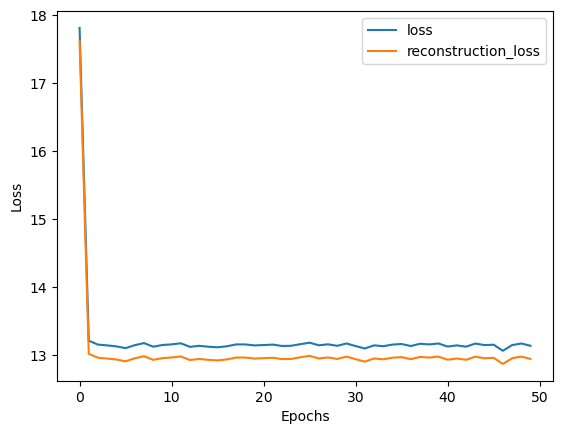

In [24]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["reconstruction_loss"], label="reconstruction_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
y_test = vae.encoder.predict(X_test)[0]

2023-11-02 09:54:14.299859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-02 09:54:14.301205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-02 09:54:14.302205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 2s 21ms/step


In [26]:
y_test

array([[0.25000405, 0.25000522, 0.2499905 , 0.25000024],
       [0.25000387, 0.2500052 , 0.24999058, 0.25000036],
       [0.2500038 , 0.25000516, 0.24999069, 0.2500004 ],
       ...,
       [0.2500041 , 0.25000504, 0.24999085, 0.25000006],
       [0.25000393, 0.25000504, 0.24999084, 0.25000018],
       [0.2500038 , 0.25000516, 0.2499907 , 0.2500004 ]], dtype=float32)

In [27]:
res = vae.decoder.predict(y_test)
res

32/32 [==============================] - 0s 5ms/step


array([[0.49993414, 0.5000558 , 0.5003055 , ..., 0.5002622 , 0.50032914,
        0.50034785],
       [0.49993414, 0.5000558 , 0.5003055 , ..., 0.5002622 , 0.50032914,
        0.50034785],
       [0.49993414, 0.5000558 , 0.5003055 , ..., 0.5002622 , 0.50032914,
        0.50034785],
       ...,
       [0.49993712, 0.5000535 , 0.5002993 , ..., 0.5002679 , 0.50032496,
        0.50035   ],
       [0.49993712, 0.5000536 , 0.5002993 , ..., 0.5002679 , 0.500325  ,
        0.50035   ],
       [0.49993712, 0.5000535 , 0.5002992 , ..., 0.5002679 , 0.500325  ,
        0.50035   ]], dtype=float32)

<StemContainer object of 3 artists>

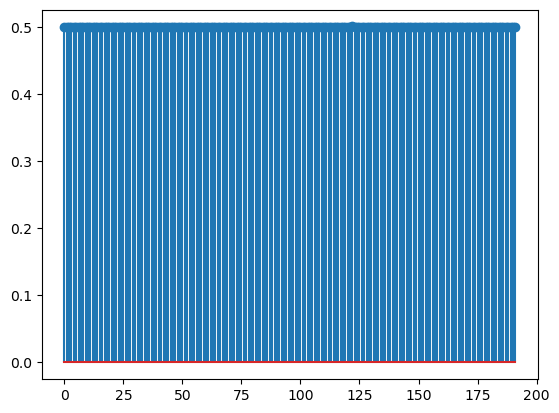

In [28]:
plt.stem(res[10,:])